In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 713 kB 8.5 MB/s 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import os 
import glob

In [3]:
import monai
from monai.optimizers import LearningRateFinder
from monai.inferers import SimpleInferer
from monai.metrics import DiceMetric
import monai.transforms as mtf
from monai.networks import one_hot
from monai.data import decollate_batch
import albumentations as A

In [4]:
!pip install einops

In [5]:
from monai.transforms import (
    AddChanneld,
    Compose,
    LoadImaged,
    CenterSpatialCropd,
    NormalizeIntensityd,
    RandSpatialCropd,
    MapTransform,
    RandGaussianNoise,
    ToTensord,
)
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.utils import first

from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.networks.nets import UNETR
from monai.networks.nets import BasicUNet
from monai.networks.nets import EfficientNetBN
from monai.networks.nets import VNet
from monai.networks.nets import RegUNet
from monai.inferers import sliding_window_inference
from monai.networks.layers import Norm

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import os
import glob

In [6]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print(device)

cuda:0


In [7]:
path1 = '/content/drive/MyDrive/21_2_Image_process_project/brats18_test' # replace your data path
dpiv = 80

In [8]:
path_list = glob.glob(os.path.join(path1,'Brats18*'))
len(path_list)

20

In [9]:
path_list = sorted(glob.glob(os.path.join(path1,'Brats18*')))
len(path_list)

20

In [10]:
for i in range(20):
  # t1ce matrix 불러오기
  img = nib.load(data_dicts[i]['image'])
  im = img.get_fdata()
  im_max_contrast = np.max(im)
  im_min_contrast = np.min(im)
  # 불러온 데이터 histogram 만들기
  cont_hist,cont_bins = np.histogram(im.flatten(),int(im_max_contrast),[int(im_min_contrast),int(im_max_contrast)])
  cont_bins = list(map(int,cont_bins)) #[Python] 리스트 각 원소들의 타입 변경
  hist_data = [[h,b] for h,b in zip(cont_hist,cont_bins)]
  use = hist_data[1:] # 0은 값이 너무 많아서 제외
  a = max(use)
  b = a[1]
  th = 2*b # thresholding
  # thresholding값 적용하기
  im[im>th] = th
  processed_max_contrast = im.max()
  processed_min_contrast = im.min()

  #새로 만든 processed_t1ce.nii.gz 저장하기
  nifti = nib.Nifti1Image(im, img.affine, img.header)
  nib.save(nifti,os.path.join(path_list[i],"pro_t1ce.nii.gz"))

  # unit8 (0-255)
  # im_8 = 255*((im-im.min())/(im.max()-im.min()))
  # nifti = nib.Nifti1Image(im_8, img.affine, img.header)
  # nib.save(nifti,os.path.join(path0,'unit8_processed.nii.gz'))
  #

NameError: ignored

In [11]:
test_transforms = Compose(
    [
      LoadImaged(keys=("image")),
      AddChanneld(keys=("image")),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
      ToTensord(keys= ["image"]),
    ]
)


In [12]:
test_ind = np.arange(0,20)
data_dicts = [
    {
        "image": os.path.join(path_list[idx],
                                    "pro_t1ce.nii.gz")
    }
    for idx in test_ind
]

In [28]:
test_files =  data_dicts

In [14]:
test_ds = Dataset(data = test_files, transform = test_transforms)
test_loader = DataLoader(test_ds,batch_size = 1)

In [15]:
device = torch.device("cuda:0")
loss_function = DiceLoss(to_onehot_y=True, softmax=True)

In [16]:
arch = "Unet"

In [17]:
if arch == "Unet":
  model = UNet(dimensions=3,in_channels=1,out_channels=2,channels=(8, 16, 32, 64,128),strides=(2, 2, 2, 2),num_res_units=3,norm=Norm.BATCH,).to(device)
elif arch == "EfficientB3":
  model = EfficientNetBN("efficientnet-b3", in_channels=1, num_classes=2 ,spatial_dims=3).to(device)
elif arch == "UNETR":
  model = UNETR(in_channels=1, out_channels=2, img_size=160, feature_size=32, norm_name='batch', spatial_dims=3).to(device)
elif arch == "BasicUnet":
  model = BasicUNet(spatial_dims=3, features=(32, 32, 64, 128, 256, 32)).to(device)
elif arch == "VNet":
  model = VNet(spatial_dims=3, in_channels=1, out_channels=2, act=('elu', {'inplace': True}), dropout_prob=0.5, dropout_dim=3, bias=False).to(device)


In [18]:
net = model.to(device)
print(type(net))
net

<class 'monai.networks.nets.unet.UNet'>


UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit2): Convolution(
          (conv): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_runni

In [19]:
import torch
from torch import nn
from torchsummary import summary as summary_
from torch.nn import functional as F
from einops import rearrange, reduce, repeat

In [20]:
summary_(model,(1,160,160,64),batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1         [1, 8, 80, 80, 32]             224
            Conv3d-2         [1, 8, 80, 80, 32]             224
       BatchNorm3d-3         [1, 8, 80, 80, 32]              16
           Dropout-4         [1, 8, 80, 80, 32]               0
             PReLU-5         [1, 8, 80, 80, 32]               1
            Conv3d-6         [1, 8, 80, 80, 32]           1,736
       BatchNorm3d-7         [1, 8, 80, 80, 32]              16
           Dropout-8         [1, 8, 80, 80, 32]               0
             PReLU-9         [1, 8, 80, 80, 32]               1
           Conv3d-10         [1, 8, 80, 80, 32]           1,736
      BatchNorm3d-11         [1, 8, 80, 80, 32]              16
          Dropout-12         [1, 8, 80, 80, 32]               0
            PReLU-13         [1, 8, 80, 80, 32]               1
     ResidualUnit-14         [1, 8, 80,

In [26]:
import nibabel as nib
path_out = os.path.join(path1,'result') # the results will be saved in this folder
if os.path.isdir(path_out)==0:
  os.mkdir(path_out)

In [27]:
root_dir = '/content/drive/MyDrive/21_2_Image_process_project/brats18_train_problem'
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model_epoch_188_ver7_data_200_UNet_12_08.pth")))

<All keys matched successfully>

In [ ]:
# constrast를 올리는 방법은 두가지 

In [29]:
test_data = test_loader

['/content/drive/MyDrive/21_2_Image_process_project/brats18_test/Brats18_test_01/pro_t1ce.nii.gz']


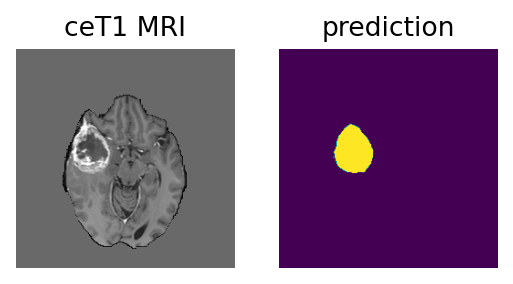

['/content/drive/MyDrive/21_2_Image_process_project/brats18_test/Brats18_test_02/pro_t1ce.nii.gz']


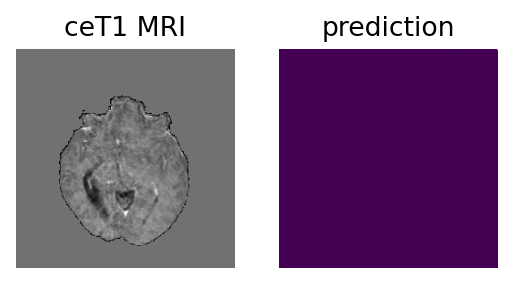

['/content/drive/MyDrive/21_2_Image_process_project/brats18_test/Brats18_test_03/pro_t1ce.nii.gz']


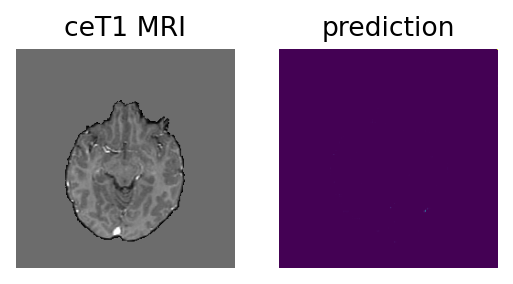

['/content/drive/MyDrive/21_2_Image_process_project/brats18_test/Brats18_test_04/pro_t1ce.nii.gz']


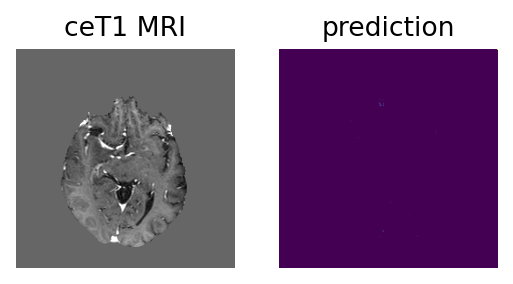

['/content/drive/MyDrive/21_2_Image_process_project/brats18_test/Brats18_test_05/pro_t1ce.nii.gz']


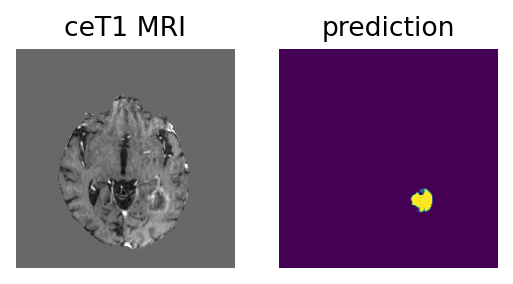

['/content/drive/MyDrive/21_2_Image_process_project/brats18_test/Brats18_test_06/pro_t1ce.nii.gz']


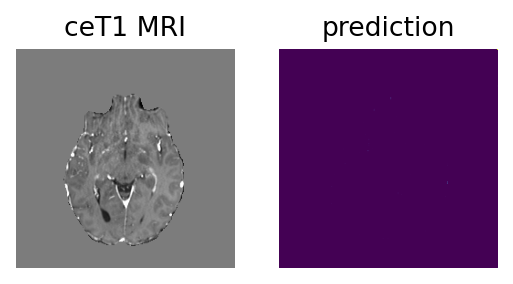

['/content/drive/MyDrive/21_2_Image_process_project/brats18_test/Brats18_test_07/pro_t1ce.nii.gz']


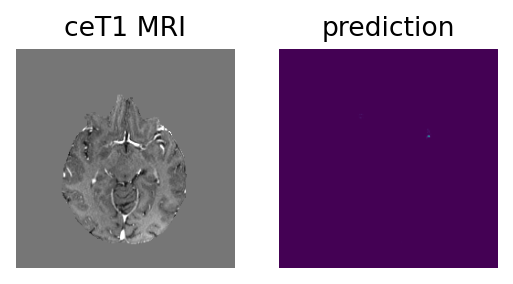

['/content/drive/MyDrive/21_2_Image_process_project/brats18_test/Brats18_test_08/pro_t1ce.nii.gz']


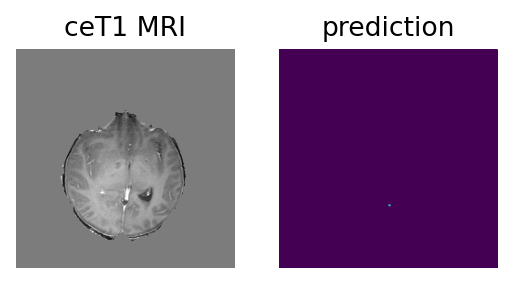

['/content/drive/MyDrive/21_2_Image_process_project/brats18_test/Brats18_test_09/pro_t1ce.nii.gz']


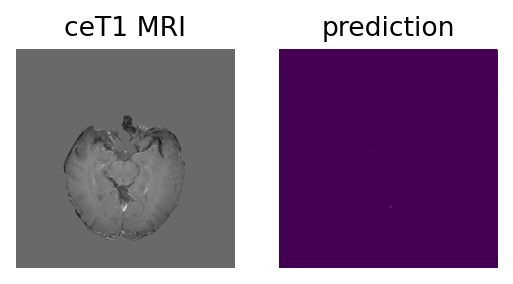

['/content/drive/MyDrive/21_2_Image_process_project/brats18_test/Brats18_test_10/pro_t1ce.nii.gz']


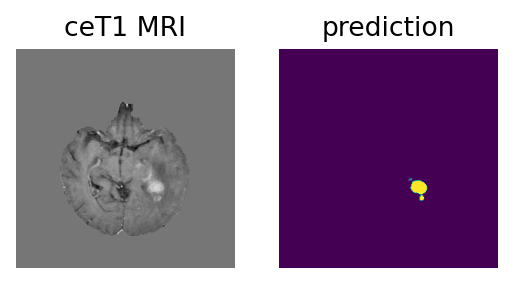

['/content/drive/MyDrive/21_2_Image_process_project/brats18_test/Brats18_test_11/pro_t1ce.nii.gz']


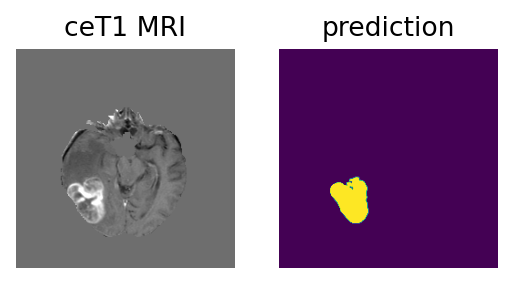

['/content/drive/MyDrive/21_2_Image_process_project/brats18_test/Brats18_test_12/pro_t1ce.nii.gz']


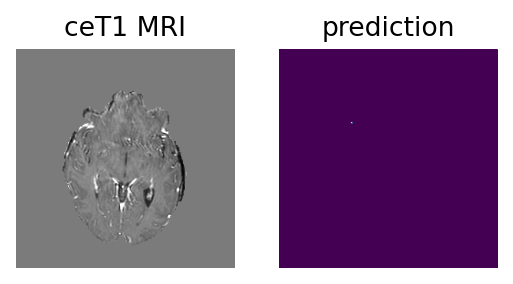

['/content/drive/MyDrive/21_2_Image_process_project/brats18_test/Brats18_test_13/pro_t1ce.nii.gz']


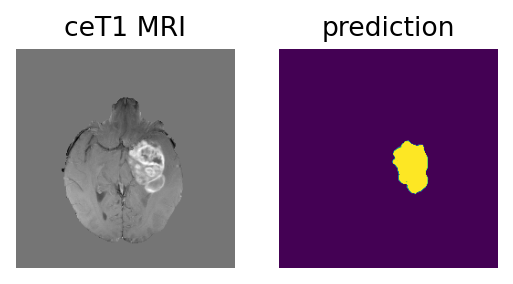

['/content/drive/MyDrive/21_2_Image_process_project/brats18_test/Brats18_test_14/pro_t1ce.nii.gz']


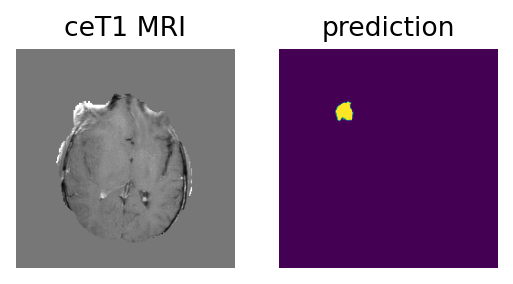

['/content/drive/MyDrive/21_2_Image_process_project/brats18_test/Brats18_test_15/pro_t1ce.nii.gz']


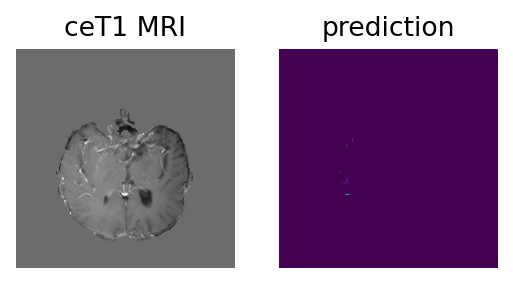

['/content/drive/MyDrive/21_2_Image_process_project/brats18_test/Brats18_test_16/pro_t1ce.nii.gz']


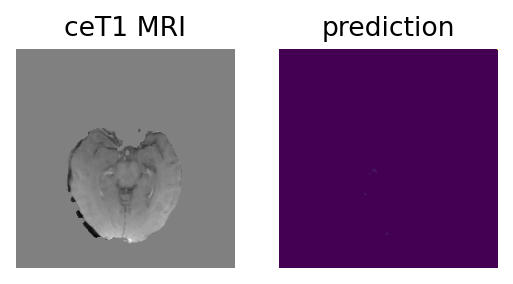

['/content/drive/MyDrive/21_2_Image_process_project/brats18_test/Brats18_test_17/pro_t1ce.nii.gz']


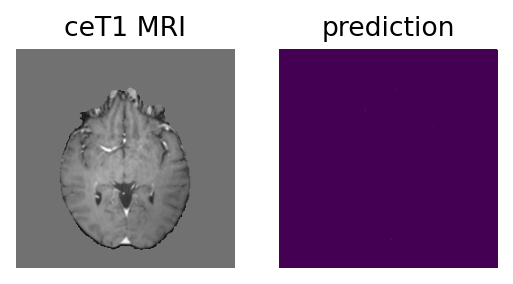

['/content/drive/MyDrive/21_2_Image_process_project/brats18_test/Brats18_test_18/pro_t1ce.nii.gz']


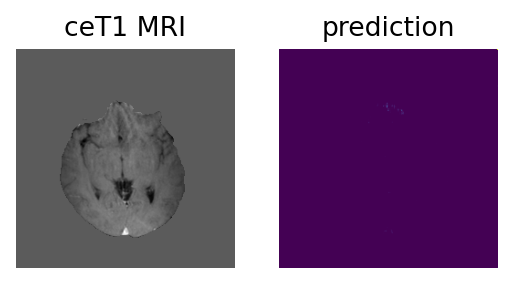

['/content/drive/MyDrive/21_2_Image_process_project/brats18_test/Brats18_test_19/pro_t1ce.nii.gz']


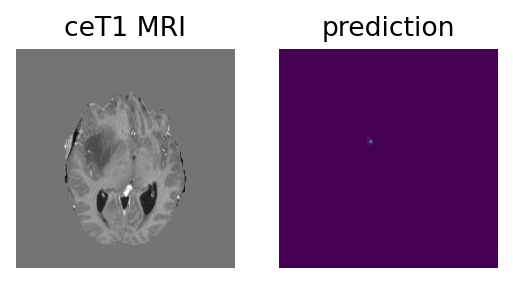

['/content/drive/MyDrive/21_2_Image_process_project/brats18_test/Brats18_test_20/pro_t1ce.nii.gz']


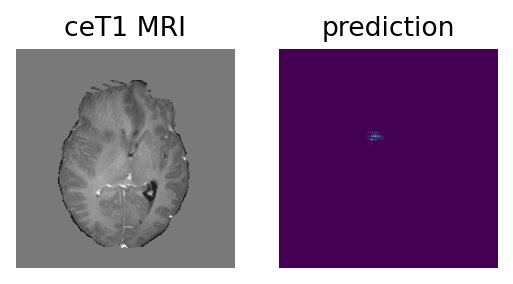

In [30]:
model.eval()
flag_save = 1

for test_data in test_data:
  with torch.no_grad():
    ts_inputs = test_data["image"].to(device)
    #val_labels = (val_labels==1).type(torch.FloatTensor)  + (val_labels==4).type(torch.FloatTensor)
    #val_labels[val_labels>0] = 1
    #val_labels = val_labels.to(device)
    roi_size = (160, 160, 64)
    sw_batch_size = 4
    ts_outputs = sliding_window_inference(
    ts_inputs, roi_size, sw_batch_size, model, overlap=0.75)
    #val_loss = loss_function(val_outputs, val_labels)
    #processed_max_contrast = im.max()
    #processed_min_contrast = im.min()
    
    print(test_data['image_meta_dict']['filename_or_obj'])
    #zz = np.argmax(np.sum(np.sum(np.array(val_labels[0,0,:,:,:].cpu()),axis=1),axis=0))
    ts_preds = ts_outputs.softmax(1)
    plt.figure(dpi=dpiv*2)
    plt.subplot(131)
    plt.imshow(np.transpose(ts_inputs[0,0,:,:,60].cpu().numpy(),(1,0)),cmap='gray')
    plt.axis('off')
    plt.title('ceT1 MRI')
    #plt.subplot(132)
    #plt.imshow(np.transpose(val_labels[0,0,:,:,zz].cpu().numpy(),(1,0)))
    #plt.axis('off')
    #plt.title('ground truth')
    plt.subplot(132)
    plt.imshow(np.transpose(ts_preds[0,1,:,:,60].cpu().numpy(),(1,0)))
    plt.axis('off')
    plt.title('prediction')
    plt.show()

    if flag_save == 1:
      ts_seg = torch.argmax(ts_preds.cpu(),dim=1).numpy()
      pid = test_data['image_meta_dict']['filename_or_obj'][0].split('/')[-2]
      h = nib.load(test_data['image_meta_dict']['filename_or_obj'][0])
      h_new=nib.Nifti1Image(ts_seg[0],h.affine,h.header)
      nib.save(h_new,os.path.join(path_out,pid+'.nii.gz'))